In [3]:
import dask
from dask.distributed import Client, progress, LocalCluster
# cluster = LocalCluster(n_workers=10)
# cluster.adapt(minimum_cores=5)
# client = Client(cluster)
# client
client = Client(n_workers=1)
# client = Client(n_workers=1)
client.restart()
client
# <Client: scheduler='tcp://172.31.33.0:8786' processes=10 cores=80>

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 1
Total threads: 8,Total memory: 7.83 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:61914,Workers: 1
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 7.83 GiB
Comm: tcp://127.0.0.1:61937,Total threads: 8
Dashboard: http://127.0.0.1:61938/status,Memory: 7.83 GiB
Nanny: tcp://127.0.0.1:61917,


In [4]:
# import dask
# dask.config.set({"distributed.comm.timeouts.connect": "50s"})
# from dask.distributed import Client,LocalCluster
# client = dask.distributed.Client(n_workers=1)

# client
    



### XGBoost Implementation on Airline Data (using Dask)

#### Load the Data

In [5]:
%%time

# client = Client(asynchronous=True, n_workers=4, threads_per_worker=2)

import dask.dataframe as dd

# Subset of the columns to use
cols = ['Year', 'Month', 'DayOfWeek', 'Distance',
        'DepDelay', 'CRSDepTime', 'UniqueCarrier', 'Origin', 'Dest']

# Create the dataframe
df = dd.read_csv('DelayedFlights.csv', usecols=cols,
                  storage_options={'anon': True})

df = df.sample(frac=0.2) # XGBoost requires a bit of RAM, we need a larger cluster

is_delayed = (df.DepDelay.fillna(16) > 15)  # column of labels
del df['DepDelay']  # Remove delay information from training dataframe

df['CRSDepTime'] = df['CRSDepTime'].clip(upper=2399)

df, is_delayed = dask.persist(df, is_delayed)  # start work in the background

Wall time: 1.88 s


In [6]:
df.head()

,Year,Month,DayOfWeek,CRSDepTime,UniqueCarrier,Origin,Dest,Distance
429272,2008,3,7,1456,YV,DEN,CPR,230
65540,2008,1,2,1445,OO,SFO,RDM,462
432841,2008,3,3,1950,OH,CVG,SAV,515
96456,2008,1,4,1305,DL,GEG,SLC,546
537841,2008,3,5,1930,AA,DEN,DFW,641


In [7]:
is_delayed.head()

429272     True
65540      True
432841     True
96456      True
537841    False
Name: DepDelay, dtype: bool

#### Categorize and One Hot Encode

##### XGBoost doesn't want to work with text data like destination="LAX". Instead we create new indicator columns for each of the known airports and carriers. This expands our data into many boolean columns. Fortunately Dask.dataframe has convenience functions for all of this baked in (thanks to Pandas!)

In [8]:
df2 = dd.get_dummies(df.categorize()).persist()

In [9]:
df2

,Year,Month,DayOfWeek,CRSDepTime,Distance,UniqueCarrier_YV,UniqueCarrier_OO,UniqueCarrier_OH,UniqueCarrier_DL,UniqueCarrier_AA,UniqueCarrier_US,UniqueCarrier_XE,UniqueCarrier_EV,UniqueCarrier_UA,UniqueCarrier_NW,UniqueCarrier_CO,UniqueCarrier_WN,UniqueCarrier_AS,UniqueCarrier_MQ,UniqueCarrier_F9,UniqueCarrier_B6,UniqueCarrier_9E,UniqueCarrier_FL,UniqueCarrier_AQ,UniqueCarrier_HA,Origin_DEN,Origin_SFO,Origin_CVG,Origin_GEG,Origin_PHL,Origin_ORF,Origin_CLT,Origin_SCE,Origin_ORD,Origin_IND,Origin_ATL,Origin_MCO,Origin_EWR,Origin_PHX,Origin_MSP,Origin_AUS,Origin_RNO,Origin_ANC,Origin_DFW,Origin_DSM,Origin_ROW,Origin_TWF,Origin_MIA,Origin_BNA,Origin_LAS,Origin_IAD,Origin_SHV,Origin_IAH,Origin_PBI,Origin_ELP,Origin_ABQ,Origin_BHM,Origin_SEA,Origin_SJC,Origin_SAN,Origin_ALB,Origin_CMH,Origin_OAK,Origin_JAC,Origin_SBA,Origin_BOS,Origin_SLC,Origin_BUF,Origin_TPA,Origin_LGA,Origin_JFK,Origin_STL,Origin_MKE,Origin_BWI,Origin_TUS,Origin_MSY,Origin_SAV,Origin_SNA,Origin_PIT,Origin_DCA,Origin_DTW,Origin_OMA,Origin_OKC,Origin_SJU,Origin_FCA,Origin_BOI,Origin_BMI,Origin_MDW,Origin_CID,Origin_SYR,Origin_DAL,Origin_MSN,Origin_ICT,Origin_SMF,Origin_LEX,Origin_ISP,Origin_ASE,Origin_HPN,Origin_PNS,Origin_HOU,Origin_TRI,Origin_RIC,Origin_IDA,Origin_LNK,Origin_LIT,Origin_MEM,Origin_LGB,Origin_RDU,Origin_RST,Origin_XNA,Origin_EVV,Origin_PSP,Origin_FWA,Origin_YUM,Origin_CLE,Origin_CPR,Origin_MHT,Origin_FLL,Origin_LAX,Origin_AEX,Origin_ONT,Origin_SGF,Origin_SDF,Origin_BIS,Origin_CHS,Origin_MCI,Origin_SAT,Origin_DAY,Origin_RSW,Origin_PDX,Origin_GSO,Origin_ATW,Origin_PSG,Origin_AVP,Origin_BTR,Origin_TYS,Origin_GRB,Origin_GRR,Origin_HDN,Origin_LBB,Origin_BUR,Origin_SBN,Origin_JAX,Origin_CHA,Origin_WRG,Origin_PVD,Origin_BET,Origin_EGE,Origin_TVC,Origin_ITO,Origin_DRO,Origin_BQN,Origin_HNL,Origin_ROC,Origin_FAI,Origin_MDT,Origin_CLD,Origin_SGU,Origin_FSD,Origin_CMI,Origin_BDL,Origin_AZO,Origin_MOB,Origin_ROA,Origin_RAP,Origin_SBP,Origin_LAN,Origin_KTN,Origin_DBQ,Origin_LFT,Origin_JAN,Origin_ABI,Origin_LIH,Origin_MAF,Origin_SWF,Origin_GSP,Origin_BZN,Origin_JNU,Origin_MRY,Origin_SRQ,Origin_STT,Origin_GNV,Origin_TUL,Origin_SCC,Origin_MFR,Origin_FSM,Origin_COS,Origin_CAE,Origin_GPT,Origin_ABE,Origin_OGG,Origin_ELM,Origin_TLH,Origin_BRO,Origin_MGM,Origin_VPS,Origin_CRP,Origin_FAY,Origin_MOD,Origin_AMA,Origin_RDD,Origin_DHN,Origin_MLI,Origin_HSV,Origin_CIC,Origin_PWM,Origin_MSO,Origin_ILM,Origin_GRK,Origin_BTV,Origin_CSG,Origin_FNT,Origin_SIT,Origin_MLU,Origin_CLL,Origin_GJT,Origin_KOA,Origin_FAT,Origin_TOL,Origin_HRL,Origin_EKO,Origin_EYW,Origin_GUC,Origin_SMX,Origin_RKS,Origin_TXK,Origin_ACV,Origin_PHF,Origin_CHO,Origin_BFL,Origin_MTJ,Origin_DLH,Origin_LAW,Origin_CRW,Origin_SLE,Origin_RDM,Origin_PIH,Origin_CEC,Origin_OME,Origin_IPL,Origin_ABY,Origin_CAK,Origin_IYK,Origin_MLB,Origin_FAR,Origin_CDV,Origin_CWA,Origin_MYR,Origin_AGS,Origin_BGR,Origin_STX,Origin_PFN,Origin_CDC,Origin_PIA,Origin_MBS,Origin_BIL,Origin_GFK,Origin_ERI,Origin_PSE,Origin_DAB,Origin_EUG,Origin_MFE,Origin_ACT,Origin_MEI,Origin_BRW,Origin_SPI,Origin_PSC,Origin_AVL,Origin_GTR,Origin_SUN,Origin_LSE,Origin_MOT,Origin_MCN,Origin_SPS,Origin_LRD,Origin_LCH,Origin_GGG,Origin_BTM,Origin_ADK,Origin_SUX,Origin_FLO,Origin_VLD,Origin_MKG,Origin_OTZ,Origin_HLN,Origin_TYR,Origin_BPT,Origin_ACY,Origin_COD,Origin_HHH,Origin_TEX,Origin_MQT,Origin_OXR,Origin_OAJ,Origin_EWN,Origin_PMD,Origin_SJT,Origin_RFD,Origin_GTF,Origin_YAK,Origin_ADQ,Origin_BQK,Origin_LYH,Origin_BLI,Origin_FLG,Origin_BGM,Origin_LWS,Origin_ALO,Origin_GCC,Origin_YKM,Origin_CMX,Origin_ACK,Origin_DLG,Origin_AKN,Origin_LMT,Origin_LWB,Origin_GST,Origin_INL,Origin_OTH,Origin_PLN,Origin_RHI,Origin_BJI,Origin_ITH,Origin_HTS,Origin_PIR,Origin_WYS,Dest_CPR,Dest_RDM,Dest_SAV,Dest_SLC,Dest_DFW,Dest_SJU,Dest_IAH,Dest_TPA,Dest_ATL,Dest_GRR,Dest_CLT,Dest_IND,Dest_BDL,Dest_SBA,Dest_DCA,Dest_PIT,Dest_LAS,Dest_FAI,Dest_SAT,Dest_JAX,Dest_PHX,Dest_ORD,Dest_LGA,Dest_SNA,Dest_LAX,Dest_EWR,Dest_AUS,Dest_CVG,Dest_SAN,Dest_DEN,Dest_SFO,Dest_ONT,Dest_MDW,Dest_TUS,D

In [10]:
len(df2.columns)

627

#### Split & Train

##### We split our data randomly in a 90%/10% split for training and testing. XGBoost is then setup and data is handed off for training

In [11]:
%%time
data_train, data_test = df2.random_split([0.9, 0.1], random_state=1234)
labels_train, labels_test = is_delayed.random_split([0.9, 0.1], random_state=1234)

print(labels_train)

Dask Series Structure:
npartitions=3
    bool
     ...
     ...
     ...
Name: DepDelay, dtype: bool
Dask Name: split, 9 tasks
Wall time: 271 ms


In [12]:
# #Categorize Data instead of keeping it as an object 

# df['UniqueCarrier'] = df.UniqueCarrier.astype('category')
# df['Origin'] = df.Origin.astype('category')
# df['Dest'] = df.Dest.astype('category')

In [13]:
# df.info()

In [14]:
%%time
import dask_xgboost as dxgb

param = {'objective': 'binary:logistic', 'nround': 1000,
          'max_depth': 16, 'eta': 0.01, 'subsample': 0.5,
          'min_child_weight': 1, 'tree_method': 'hist',
          'grow_policy': 'lossguide'}

# param = {
#     'max_depth': 3,  # the maximum depth of each tree
#     'eta': 0.3,  # the training step for each iteration
#     'objective': 'multi:softprob',  # error evaluation for multiclass training
#     'num_class': 3,
#     # 'silent': 0, 
#     'eval_metric':'mlogloss'}  # the number of classes that exist in this datset
# num_round = 200  # the number of training iterations



bst = dxgb.train(client, param, data_train, labels_train)

Wall time: 46.4 s


###### Our output is just a normal XGBoost Booster object.

In [15]:
bst

In [16]:
# dask-xgboost is used to predict in parallel across the cluster
predictions = dxgb.predict(client, bst, data_test).persist()
predictions

dask.array<values, shape=(nan,), dtype=float32, chunksize=(nan,), chunktype=numpy.ndarray>

### XGBoost Implementation on Airline Data (without Dask)

#### Load the Data

In [24]:
%%time
import numpy as np
import pandas as pd

cols = ['Year', 'Month', 'DayOfWeek', 'Distance',
        'DepDelay', 'CRSDepTime', 'UniqueCarrier', 'Origin', 'Dest']


dfpd = pd.read_csv('DelayedFlights.csv', usecols=cols)


dfpd = dfpd.sample(frac=0.2) # XGBoost requires a bit of RAM, we need a larger cluster

is_delayed_col = (dfpd.DepDelay.fillna(16) > 15)  # column of labels
del dfpd['DepDelay']  # Remove delay information from training dataframe

dfpd['CRSDepTime'] = dfpd['CRSDepTime'].clip(upper=2399)


dfpd.head()

Wall time: 8.27 s


,Year,Month,DayOfWeek,CRSDepTime,UniqueCarrier,Origin,Dest,Distance
1074472,2008,6,6,1555,CO,EWR,MCO,938
1374022,2008,8,6,1925,MQ,ORD,OKC,693
130156,2008,1,1,1310,MQ,LGA,CLT,544
1076745,2008,6,2,840,DL,ATL,LGA,761
644064,2008,4,1,1530,US,PHL,ORD,678


In [18]:
is_delayed_col.head()


1453421     True
1123243    False
1401501     True
520702      True
1691224    False
Name: DepDelay, dtype: bool

In [19]:
df.info() 


<class 'dask.dataframe.core.DataFrame'>
Columns: 8 entries, Year to Distance
dtypes: object(3), int64(5)

In [20]:
# %%time

# # normal xgboost w/o dask

# # from sklearn.cross_validation import train_test_split
# # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1234, stratify=y)

# import xgboost as xgb

# from sklearn.model_selection import train_test_split

# dfpd['UniqueCarrier'] = dfpd.UniqueCarrier.astype('category')
# dfpd['Origin'] = dfpd.Origin.astype('category')
# dfpd['Dest'] = dfpd.Dest.astype('category')

# # X is training data & Y is test_data
# X = dfpd
# y = is_delayed_col

# # print(y)
# # X = dfpd
# # y = is_delayed_col
# X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.1, random_state=1234)


# # print(X_train)

# # X_train = training_data.iloc[:,:]
# # X_test = test_data.iloc[:,:]

# # pd.get_dummies(data=dfpd, columns=['UniqueCarrier', 'Origin', 'Dest'], dtype='int')
# # dfpd['UniqueCarrier'] = pd.to_numeric(dfpd['UniqueCarrier'])
# # dfpd['Origin'] = pd.to_numeric(dfpd['Origin'])
# # dfpd['Dest'] = pd.to_numeric(dfpd['Dest'])


# # dfpd.info()
# dtrain = xgb.DMatrix(X_train, enable_categorical=True, label=y_train)
# # ltrain = xgb.DMatrix(y_train, enable_categorical=True)

# dtrain

# # lala import xgboost as xgb
# # read in data
# # laladtrain = xgb.DMatrix(data_train)
# # pandas_df = data_train.head()
# # dtrain = xgb.DMatrix(pandas_df)
# # print(dtrain)

# # specify parameters via map
# params = {'objective': 'binary:logistic', 'nround': 1000,
#           'max_depth': 16, 'eta': 0.01, 'subsample': 0.5,
#           'min_child_weight': 1, 'tree_method': 'hist',
#           'grow_policy': 'lossguide'}
# num_round = 2

# # clf = xgb.XGBClassifier(**params)

# # clf

# # print(params)

# # do tom
# bst = xgb.train(client, params, dtrain)
# # # make prediction
# # preds = bst.predict(dtest)

In [21]:
# %%time

# # normal xgboost w/o dask

# # from sklearn.cross_validation import train_test_split
# # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1234, stratify=y)

# import xgboost as xgb

# from sklearn.model_selection import train_test_split

# dfpd['UniqueCarrier'] = dfpd.UniqueCarrier.astype('category')
# dfpd['Origin'] = dfpd.Origin.astype('category')
# dfpd['Dest'] = dfpd.Dest.astype('category')

# # X is training data & Y is test_data
# X = dfpd
# y = is_delayed_col

# # print(y)
# # X = dfpd
# # y = is_delayed_col
# X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.1, random_state=1234)




In [22]:
df2.head()

,Year,Month,DayOfWeek,CRSDepTime,Distance,UniqueCarrier_YV,UniqueCarrier_OO,UniqueCarrier_OH,UniqueCarrier_DL,UniqueCarrier_AA,...,Dest_DLG,Dest_LWB,Dest_WYS,Dest_GST,Dest_LMT,Dest_AKN,Dest_INL,Dest_BJI,Dest_HTS,Dest_ITH
429272,2008,3,7,1456,230,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
65540,2008,1,2,1445,462,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
432841,2008,3,3,1950,515,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
96456,2008,1,4,1305,546,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
537841,2008,3,5,1930,641,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


#### Using larger dataset. nPartitions = 3 

In [23]:
%%time

import numpy as np
import xgboost as xgb
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.datasets import dump_svmlight_file
# from sklearn.externals import joblib
from sklearn.metrics import precision_score

data_train, data_test = df2.random_split([0.9, 0.1], random_state=1234)
labels_train, labels_test = is_delayed.random_split([0.9, 0.1], random_state=1234)

# use DMatrix for xgbosot
dtrain = xgb.DMatrix(data_train,enable_categorical=True, label=labels_train)
dtest = xgb.DMatrix(data_test,enable_categorical=True, label=labels_test)



# set xgboost params
param = {
    'max_depth': 3,  # the maximum depth of each tree
    'eta': 0.3,  # the training step for each iteration
    'objective': 'multi:softprob',  # error evaluation for multiclass training
    'num_class': 3,
    'eval_metric':'mlogloss'}  # the number of classes that exist in this datset
num_round = 200  # the number of training iterations



#------------- numpy array ------------------
# training and testing - numpy matrices
bst = xgb.train(param, dtrain, num_round)
preds = bst.predict(dtest)

# extracting most confident predictions
best_preds = np.asarray([np.argmax(line) for line in preds])
print ("Numpy array precision:", precision_score(labels_test, best_preds, average='macro'))



Numpy array precision: 0.6111177790376026
Wall time: 16min 32s


#### Using dataset that is non-partitioned. (dfpd)

In [25]:
%%time

import numpy as np
import xgboost as xgb
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.datasets import dump_svmlight_file
# from sklearn.externals import joblib
from sklearn.metrics import precision_score


dfpd['UniqueCarrier'] = dfpd.UniqueCarrier.astype('category')
dfpd['Origin'] = dfpd.Origin.astype('category')
dfpd['Dest'] = dfpd.Dest.astype('category')

dfpd.info()

# X is training data & Y is test_data
X = dfpd
y = is_delayed_col

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

# use DMatrix for xgboost
dtrain2 = xgb.DMatrix(X_train,enable_categorical=True, label=y_train)
dtest2 = xgb.DMatrix(X_test,enable_categorical=True, label=y_test)


# set xgboost params
param = {
    'max_depth': 3,  # the maximum depth of each tree
    'eta': 0.3,  # the training step for each iteration
    'objective': 'multi:softprob',  # error evaluation for multiclass training
    'num_class': 3,
    'eval_metric':'mlogloss'}  # the number of classes that exist in this datset
num_round = 200  # the number of training iterations

# param = {'objective': 'binary:logistic', 'nround': 1000,
#           'max_depth': 3, 'eta': 0.01, 'subsample': 0.5,
#           'min_child_weight': 1, 'tree_method': 'hist',
#           'grow_policy': 'lossguide','eval_metric':'mlogloss'}
# num_round = 2



#------------- numpy array ------------------
# training and testing - numpy matrices
bstt = xgb.train(param, dtrain2, num_round)
preds = bstt.predict(dtest2)

# extracting most confident predictions
best_preds = np.asarray([np.argmax(line) for line in preds])
print ("Numpy array precision:", precision_score(y_test, best_preds, average='macro'))


<class 'pandas.core.frame.DataFrame'>
Int64Index: 387352 entries, 1074472 to 798324
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype   
---  ------         --------------   -----   
 0   Year           387352 non-null  int64   
 1   Month          387352 non-null  int64   
 2   DayOfWeek      387352 non-null  int64   
 3   CRSDepTime     387352 non-null  int64   
 4   UniqueCarrier  387352 non-null  category
 5   Origin         387352 non-null  category
 6   Dest           387352 non-null  category
 7   Distance       387352 non-null  int64   
dtypes: category(3), int64(5)
memory usage: 19.6 MB
Numpy array precision: 0.6074284022519432
Wall time: 47.1 s


### Plotting ROC Curve

#### ( A plot using Prediction Values calculated with Dask )

In [25]:
import matplotlib.pyplot as plt

In [61]:
from sklearn.metrics import roc_auc_score, roc_curve
print("ROC_AUC Score : ",roc_auc_score(labels_test.compute(), predictions.compute()))

ROC_AUC Score :  0.6209879690810529


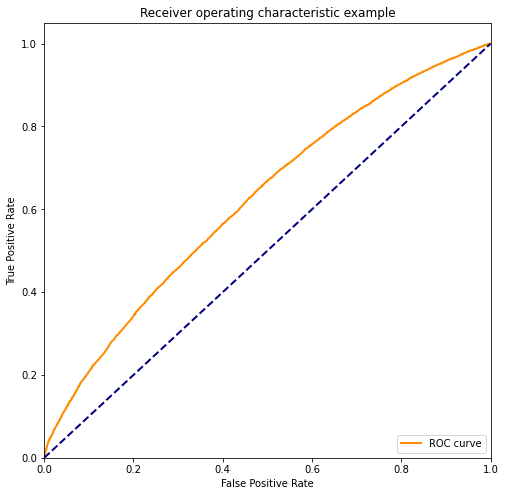

In [22]:
fpr, tpr, _ = roc_curve(labels_test.compute(), predictions.compute())
# Taken from http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py
plt.figure(figsize=(8, 8))
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

#### ( A plot using Prediction Values calculated without Dask )

ROC_AUC Score :  0.5302041846118072


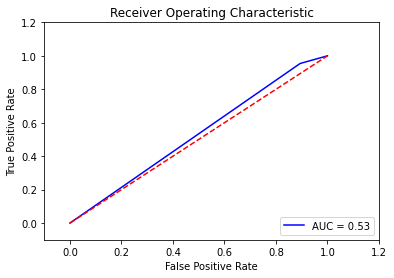

In [62]:
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def create_roc_curve(labels, scores):
  fpr, tpr, thresholds = metrics.roc_curve(labels, scores)
  roc_auc = metrics.auc(fpr, tpr)
  print("ROC_AUC Score : ",roc_auc)

  plt.title('Receiver Operating Characteristic')
  plt.plot(fpr, tpr, 'b', label='AUC = %0.2f'% roc_auc)
  plt.legend(loc='lower right')
  plt.plot([0,1],[0,1],'r--')
  plt.xlim([-0.1,1.2])
  plt.ylim([-0.1,1.2])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()

# y = np.array([0, 0, 1, 1])
# scores = np.array([0.1, 0.4, 0.35, 0.8])

create_roc_curve(y_test, best_preds)